## Load CIFAR-10 dataset

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
src = 'data/cifar-10-batches-py/'

def load_batch(file):
    with open(file, 'rb') as fo:
        dic_batch = pickle.load(fo, encoding='latin1')
    return dic_batch['data'], dic_batch['labels']

def load_cifar10(src):
    dataset = {'train_X':[],
               'train_Y':[],
               'test_X':[],
               'test_Y':[]}
    # train
    for i in range(1,6):
        data, labels = load_batch("{0}data_batch_{1}".format(src, i))        
        dataset['train_X'].append(data)
        dataset['train_Y'].append(labels)
    dataset['train_X'] = np.array(dataset['train_X'])
    dataset['train_X'] = dataset['train_X'].reshape((50000, 3, 32, 32))
    dataset['train_X'] = dataset['train_X'].transpose((0, 2, 3, 1))
    dataset['train_Y'] = np.array(dataset['train_Y']).reshape(-1,)
    # test
    data, labels = load_batch("{0}test_batch".format(src))
    data = data.reshape((10000, 3, 32, 32))
    dataset['test_X'] = data.transpose((0, 2, 3, 1))
    dataset['test_Y'] = np.array(labels)
    return dataset

dataset = load_cifar10(src)

In [3]:
np.save(src+'cifar10.npy', dataset)

In [ ]:
dataset = np.load(src+'cifar10.npy')

## Generate traditional image features

In [4]:
from skimage.feature import hog as HOG
from skimage.feature import local_binary_pattern as LBP
from skimage.feature import corner_harris as CH
from skimage.color import rgb2gray
import cv2

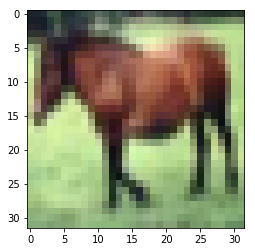

In [41]:
plt.imshow(dataset['train_X'][7])

### HOG

In [5]:
train_X_hog = []
test_X_hog = []
for i in range(50000):
    hog = HOG(dataset['train_X'][i])
    train_X_hog.append(hog)
for i in range(10000):
    hog = HOG(dataset['test_X'][i])
    test_X_hog.append(hog)
train_X_hog = np.array(train_X_hog)
test_X_hog = np.array(test_X_hog)

C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


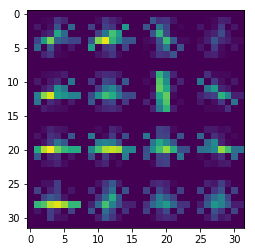

In [55]:
# 别改，因为没有返回图片了
plt.imshow(hog[1])

### LBP local_binary_pattern

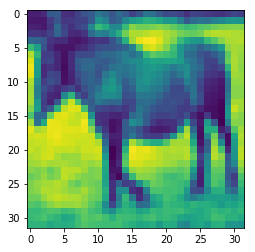

In [63]:
gray = rgb2gray(dataset['train_X'][7])
plt.imshow(gray)

In [6]:
train_X_lbp = []
test_X_lbp = []
for i in range(50000):
    gray = rgb2gray(dataset['train_X'][i])
    lbp = LBP(gray, P=3, R=3)
    train_X_lbp.append(lbp.reshape((1024,)))
for i in range(10000):
    gray = rgb2gray(dataset['test_X'][i])
    lbp = LBP(gray, P=3, R=3)
    test_X_lbp.append(lbp.reshape((1024,)))
train_X_lbp = np.array(train_X_lbp)
test_X_lbp = np.array(test_X_lbp)

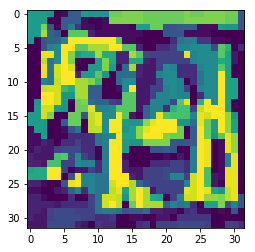

In [75]:
plt.imshow(lbp)

### Corner Harris

In [7]:
train_X_ch = []
test_X_ch = []
for i in range(50000):
    gray = rgb2gray(dataset['train_X'][i])
    ch = CH(gray)
    train_X_ch.append(ch.reshape((1024,)))
for i in range(10000):
    gray = rgb2gray(dataset['test_X'][i])
    ch = CH(gray)
    test_X_ch.append(ch.reshape((1024,)))
train_X_ch = np.array(train_X_ch)
test_X_ch = np.array(test_X_ch)

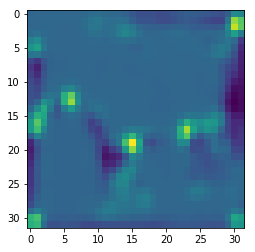

In [83]:
plt.imshow(ch)

### SIFT

In [62]:
# 先不管SIFT了。。
sift = cv2.xfeatures2d.SIFT_create(200)
train_X_sift = []
test_X_sift = []
for i in range(5):
    #keypoints
    kp, des = sift.detectAndCompute(dataset['train_X'][i],None)
    print(des.shape)
    train_X_sift.append(des.reshape(-1,))
for i in range(10):
    kp, des = sift.detectAndCompute(dataset['test_X'][i],None)
    test_X_sift.append(des.reshape((-1,)))
train_X_sift = np.array(train_X_sift)
test_X_sift = np.array(test_X_sift)

(18, 128)
(18, 128)
(13, 128)
(11, 128)
(13, 128)


In [57]:
train_X_sift.shape

(5,)

## Generate classifier

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [9]:
# conbine features
train_X_ft = np.hstack((train_X_hog, train_X_lbp))
train_X_ft = np.hstack((train_X_ft, train_X_ch))
test_X_ft = np.hstack((test_X_hog, test_X_lbp))
test_X_ft = np.hstack((test_X_ft, test_X_ch))

In [68]:
train_X_ft.shape

(50000, 2372)

In [12]:
features = {'ori':[dataset['train_X'].reshape(50000,-1), dataset['test_X'].reshape(10000,-1)],
            'combined':[train_X_ft, test_X_ft],
            'hog':[train_X_hog, test_X_hog], 
            'lbp':[train_X_lbp, test_X_lbp], 
            'ch':[train_X_ch, test_X_ch]}

In [13]:
np.save(src+'features', features)

### Logistic regression

In [14]:
lg = LogisticRegression(penalty='l2', 
                        dual=False, 
                        tol=0.0001, 
                        C=1.0,
                        fit_intercept=True, 
                        intercept_scaling=1, 
                        class_weight=None, 
                        random_state=None, 
                        solver='lbfgs', 
                        max_iter=1000, 
                        multi_class='auto', 
                        verbose=2, 
                        warm_start=False, 
                        n_jobs=None)

In [79]:
classification_report(dataset['test_Y'], pred)

'              precision    recall  f1-score   support\n\n           0       0.30      0.28      0.29      1000\n           1       0.40      0.40      0.40      1000\n           2       0.25      0.27      0.26      1000\n           3       0.21      0.19      0.20      1000\n           4       0.21      0.23      0.22      1000\n           5       0.30      0.26      0.28      1000\n           6       0.25      0.26      0.25      1000\n           7       0.37      0.38      0.38      1000\n           8       0.39      0.42      0.40      1000\n           9       0.40      0.40      0.40      1000\n\n   micro avg       0.31      0.31      0.31     10000\n   macro avg       0.31      0.31      0.31     10000\nweighted avg       0.31      0.31      0.31     10000\n'

In [81]:
confusion_matrix(dataset['test_Y'], pred)

array([[284,  50, 123,  49,  89,  54,  65,  58, 158,  70],
       [ 55, 395,  16,  44,  36,  34,  71,  68,  76, 205],
       [ 83,  20, 271, 121, 153,  83, 113,  51,  70,  35],
       [ 60,  48, 121, 186, 124, 145, 119,  95,  55,  47],
       [ 68,  48, 163, 110, 227,  91, 124,  94,  59,  16],
       [ 57,  23, 124, 127, 130, 261, 106,  96,  46,  30],
       [ 69,  79, 102, 127, 137,  73, 257,  70,  47,  39],
       [ 48,  43,  79,  57, 102,  78,  73, 382,  60,  78],
       [135,  88,  71,  44,  48,  30,  47,  43, 416,  78],
       [ 80, 203,  22,  29,  29,  25,  45,  80,  91, 396]], dtype=int64)

In [15]:
for ft in features:
    lg.fit(feature[ft][0], dataset['train_Y'])
    acc = lg.score(feature[ft][1], dataset['test_Y'])
    print("When feature is {0}, the accuracy is {1}".format(ft, acc))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


When feature is combined, the accuracy is 0.3676


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s finished


When feature is hog, the accuracy is 0.4864


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min finished


When feature is ori, the accuracy is 0.3735


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


When feature is ch, the accuracy is 0.3153
When feature is lbp, the accuracy is 0.2303


C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


### XGBoost

In [16]:
import xgboost as xgb

In [17]:
dtrain = xgb.DMatrix(data=features['hog'][0], label=dataset['train_Y'])
dtest = xgb.DMatrix(data=features['hog'][1], label=dataset['test_Y'])

In [34]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # 多分类的问题
    'num_class': 10,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。alias: min_split_loss
    'max_depth': 12,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。alias: reg_lambda
    'subsample': 0.7,              # 随机采样训练样本，行采样
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,         # ?The larger min_child_weight is, the more conservative the algorithm will be.
    'verbosity': 2,                # 0 (silent), 1 (warning), 2 (info), 3 (debug).
    'eta': 0.007,                  # alias: learning_rate range: [0,1]
    'seed': 1000,
    'nthread': 4,                  # cpu 线程数
    'eval_metric': ['merror', 'mlogloss']
}
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [35]:
num_round = 15
bst = xgb.train(params, dtrain, num_round, evallist)

[0]	eval-merror:0.6507	eval-mlogloss:2.2965	train-merror:0.43512	train-mlogloss:2.29232
[1]	eval-merror:0.599	eval-mlogloss:2.29038	train-merror:0.33512	train-mlogloss:2.28216
[2]	eval-merror:0.5685	eval-mlogloss:2.28436	train-merror:0.2819	train-mlogloss:2.27198
[3]	eval-merror:0.5461	eval-mlogloss:2.27833	train-merror:0.25156	train-mlogloss:2.26202
[4]	eval-merror:0.5384	eval-mlogloss:2.27256	train-merror:0.2273	train-mlogloss:2.25205
[5]	eval-merror:0.5218	eval-mlogloss:2.26676	train-merror:0.20994	train-mlogloss:2.24221
[6]	eval-merror:0.5122	eval-mlogloss:2.26092	train-merror:0.19988	train-mlogloss:2.23252
[7]	eval-merror:0.5084	eval-mlogloss:2.25523	train-merror:0.1898	train-mlogloss:2.2229
[8]	eval-merror:0.508	eval-mlogloss:2.24967	train-merror:0.18186	train-mlogloss:2.21336
[9]	eval-merror:0.5041	eval-mlogloss:2.2441	train-merror:0.17598	train-mlogloss:2.20388
[10]	eval-merror:0.5002	eval-mlogloss:2.23848	train-merror:0.17124	train-mlogloss:2.19446
[11]	eval-merror:0.4975	eval

In [36]:
pred = bst.predict(dtest)

In [37]:
accuracy_score(dataset['test_Y'], pred)

0.5094

In [ ]:
bst.save_model('0001.model')

In [ ]:
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('model.bin')  # load data

### Perceptron

In [ ]:
pct = Perceptron(penalty=None, 
                 alpha=0.0001, 
                 fit_intercept=True, 
                 max_iter=1000, 
                 tol=0.001, 
                 shuffle=True, 
                 verbose=2, 
                 eta0=1.0, 
                 n_jobs=None, 
                 random_state=0, 
                 early_stopping=False, 
                 validation_fraction=0.1,
                 n_iter_no_change=5, 
                 class_weight=None, 
                 warm_start=False)

In [ ]:
pct.fit(train_X_ft, train_Y)

In [ ]:
pct.score(test_X_ft, test_Y)

### Nearest Neighbors